In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("ggplot")
pd.set_option("display.max_columns",300)
from pandas.tools.plotting import scatter_matrix


from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline, NaturalCubicSpline) 

from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)

from regression_tools.plotting_tools import (
    plot_univariate_smooth,
    bootstrap_train,
    display_coef,
    plot_bootstrap_coefs,
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)

# Questions

1. Can I predict income inequality in a county (measured by difference between top income quintile and bottom income quintile) based on factors like:
    - Educational attainment - 
    - Proportion of population major ethnic groups - 
    - Population density - **done**
    - Birth rate - **done**
    - Unemployment rate - need to find
    - Target - diff between lowest and highest quintile **done** https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=bkmk
        - this will be positive, bounded by zero. 
        - likely NA's for some low-pop counties
2. Does median education rate impact income inequality?
3. Does birth rate impact income inequality?

# Goals for 3/13

1. Procure all listed datapoints not already in the data folder
2. Initial EDA to determine distribution of data and appropriate treatment
3. Figure out how to use:
    - education 
        - just median # of year at school?
        - **this option** - distribution across buckets (no high school diploma, some college, college degree, graduate degree)
    - major ethnic groups
        - **this option** - should do proportions of each race within county?
        - is there a standard measure of diversity?

In [2]:
def remove_columns(df, keyword):
    for column_name in df.columns:
        if keyword in column_name:
            df.drop(column_name, axis=1, inplace=True)
    return df

In [3]:
def update_column_names(df, phrase_to_remove, phrase_to_append=''):
    column_list = []
    for column_name in df.columns:
        if phrase_to_remove in column_name:
            column_name = column_name.replace(phrase_to_remove,'') + ' ' + phrase_to_append
        column_list.append(column_name.strip())
    df.columns = column_list
    return df

In [4]:
def add_pct_columns(df, column_names_to_pct, denom_column_name):
    for column_name in column_names_to_pct:
        df[column_name+'%'] = df[column_name]/df[denom_column_name]
    return df

In [5]:
def convert_to_pct_columns(df, column_names_to_pct, denom_column_name):
    for column_name in column_names_to_pct:
        df[column_name] = df[column_name]/df[denom_column_name]
    return df

In [6]:
''' Quintiles prep

Table is grouped by county with income means for 5 quintiles and mean for top 5%

Get data from here https://factfinder.census.gov/faces/tableservices
B19081	MEAN HOUSEHOLD INCOME OF QUINTILES
Universe: Households
Geography: All counties in US
2011-2015 American Community Survey 5-Year Estimate
'''

quintiles = pd.read_csv('data/ACS_15_5YR_B19081_with_ann.csv', header=1, encoding = "ISO-8859-1")

# drop redundant ID column
quintiles.drop('Id', axis=1, inplace=True)
# remove error columns
quintiles = remove_columns(quintiles,'Error')
# update column names to remove redundant header elements
quintiles = update_column_names(quintiles, 'Estimate; Quintile Means: - ','Mean')
# rename county columns to be consistent with other tables, rename top 5 mean to be consistent with other columns
quintiles.rename(columns={'Id2':'County_Code','Geography':'County_State','Estimate; Top 5 Percent':'Top 5% Mean' }, inplace=True)

# create income disparity column
quintiles['Diff HighestQ-LowestQ'] = quintiles['Highest Quintile Mean']\
                                    - quintiles['Lowest Quintile Mean']
quintiles['Diff Top5%-LowestQ'] = quintiles['Top 5% Mean']\
                                    - quintiles['Lowest Quintile Mean']


''' Birth Rate Prep '''

# Get data from data folder provided. Reduce to only the columns we care about
pop_estimates = pd.read_csv('data/co-est2015-alldata-utf8-3142.csv')
birth_rate = pop_estimates.loc[:,['STATE','COUNTY','STNAME','CTYNAME','POPESTIMATE2015','BIRTHS2015','RBIRTH2015']]
birth_rate.columns = ['State', 'County_Code_drop', 'State_Name', 'County_Name', 'Pop_2015', 'Births_2015','Birth_Rate_2015']
# Create new numeric column for county code with state + 000 county to enable merging with other dataframes
birth_rate['County_Code_drop']= birth_rate['County_Code_drop'].astype(str,'000').apply(lambda x: '{0:0>3}'.format(x))
birth_rate['County_Code'] = (birth_rate['State'].astype(str) + birth_rate['County_Code_drop']).astype(int)
birth_rate.drop('County_Code_drop', axis=1, inplace=True)


''' Population density prep '''

master = pd.read_csv('data/2015_master_sd_rnd_nan_to_min.csv')
master.rename(columns={'geo_id':'County_Code'}, inplace=True)
pop_density = master.loc[:,['County_Code','pop_den_2015']]    
    
''' Education prep

Table is grouped by county with county population and # of adults in each bucket

Get data from here https://factfinder.census.gov/faces/tableservices
S1501	EDUCATIONAL ATTAINMENT  more information
2011-2015 American Community Survey 5-Year Estimates
ONLY include education rates for adults 25 years and up because this seems to be 
the census standard for assessing the population education rate at large '''

# import data
education_25yr = pd.read_csv('data/ACS_15_5YR_S1501_with_ann.csv', header=1, encoding = "ISO-8859-1")
# drop redundant ID column
education_25yr.drop('Id', axis=1, inplace=True)
# remove error columns
education_25yr = remove_columns(education_25yr,'Error')
# update column names to remove redundant header elements
education_25yr = update_column_names(education_25yr, 'Total; Estimate; Population 25 years and over - ')
# rename county columns to be consistent with other tables
education_25yr.rename(columns={'Id2':'County_Code','Geography':'County_State',\
                               'Total; Estimate; Population 25 years and over':'Pop_25_years_and_over'}, inplace=True)

# change columns for rate
education_25yr = convert_to_pct_columns(education_25yr, ['Less than 9th grade',
       '9th to 12th grade, no diploma',
       'High school graduate (includes equivalency)',
       'Some college, no degree', "Associate's degree", "Bachelor's degree",
       'Graduate or professional degree'], 'Pop_25_years_and_over')


''' Racial Groups Prep

DP05	ACS DEMOGRAPHIC AND HOUSING ESTIMATES  more information
2011-2015 American Community Survey Selected Population Tables
limitation is only includes information for people who identify as a single race.

'''

# import data
race = pd.read_csv('data/ACS_15_SPT_DP05_with_ann.csv', header=1, encoding = "ISO-8859-1")

# rename county columns to be consistent with other tables
race.rename(columns={'Id2':'County_Code','Geography':'County_State'}, inplace=True)
race['County_Code'].unique().shape
# Create pivot table to make race column headers
race_pivot = pd.pivot_table(race, index= ['County_Code','County_State'],\
                            values = 'Estimate; SEX AND AGE - Total population', \
                            columns = 'Population Group', aggfunc='sum')
race_pivot.fillna(value=0, inplace=True)
race_pivot = pd.DataFrame(race_pivot.to_records())

# Turn race variables into percentages
race_pivot['Single_Race_Population']=race_pivot.iloc[:,2:].sum(axis=1)
race_pivot.columns = ['County_Code', 'County_State',
       'American Indian/Alaska Native',
       'Asian', 'Black/African American',
       'Native Hawaiian/Pacific Islander',
       'Other', 'White', 'Single_Race_Population']

race_pivot = convert_to_pct_columns(race_pivot, ['American Indian/Alaska Native','Asian', 'Black/African American',\
                                          'Native Hawaiian/Pacific Islander','Other', 'White'],'Single_Race_Population')
                
# race_pivot.head()
# race_pivot.head()
# quintiles.tail()
# birth_rate.head()
# pop_density.head()
# education_25yr.head().round(2)

In [7]:
education_25yr.head()

,County_Code,County_State,Pop_25_years_and_over,Less than 9th grade,"9th to 12th grade, no diploma",High school graduate (includes equivalency),"Some college, no degree",Associate's degree,Bachelor's degree,Graduate or professional degree
0,1001,"Autauga County, Alabama",36319,0.038382,0.089815,0.335417,0.225860,0.078224,0.134833,0.097470
1,1003,"Baldwin County, Alabama",137001,0.032007,0.072810,0.287815,0.226860,0.090656,0.192612,0.097240
2,1005,"Barbour County, Alabama",18808,0.092088,0.174872,0.345066,0.191036,0.071778,0.075074,0.050085
3,1007,"Bibb County, Alabama",15629,0.069486,0.124000,0.420628,0.218376,0.061040,0.060529,0.045940
4,1009,"Blount County, Alabama",39408,0.069656,0.145326,0.334424,0.223990,0.097696,0.086175,0.042732


/home/alex/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5,1,'Diff Top5%-LowestQ Log')

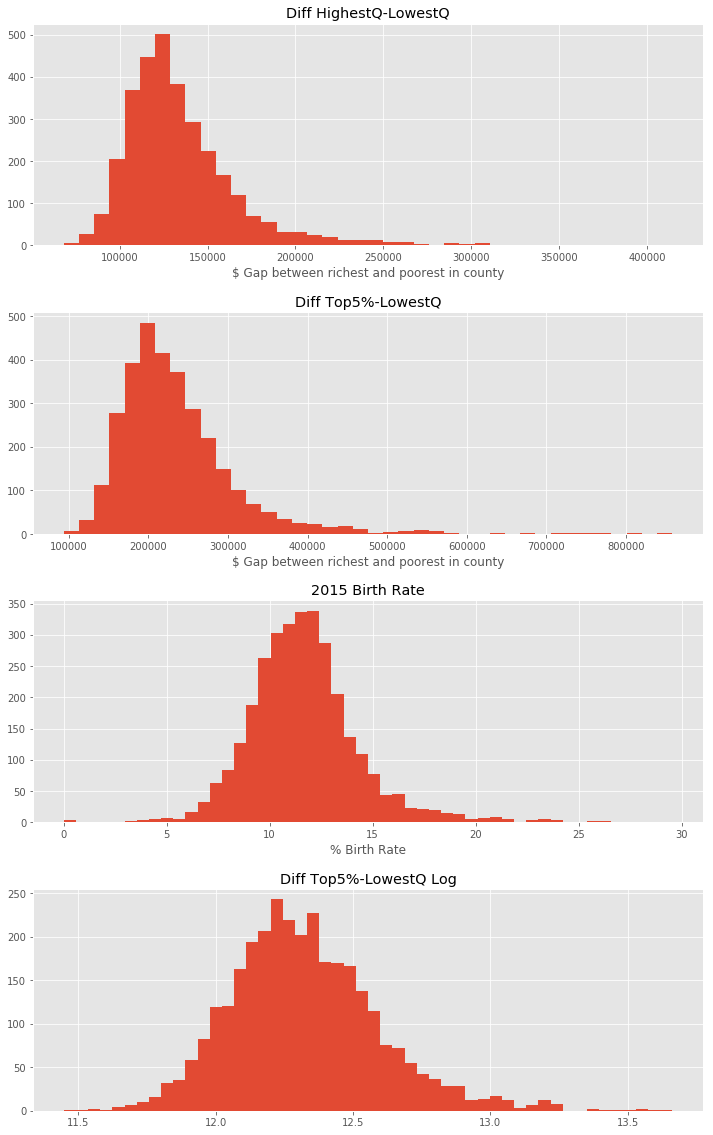

In [8]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,figsize=(12,20))
# visualization
quintiles.hist(column = ['Diff HighestQ-LowestQ','Diff Top5%-LowestQ'], bins= 40, sharex=True, figsize=(10,4), ax=(ax1,ax2));
birth_rate.hist(column = 'Birth_Rate_2015', bins = 50, ax=ax3)
ax1.set_xlabel('$ Gap between richest and poorest in county')
ax2.set_xlabel('$ Gap between richest and poorest in county')
ax3.set_title('2015 Birth Rate')
ax3.set_xlabel('% Birth Rate')
#log transform quintiles
quintiles['Diff Top5%-LowestQ'].apply(np.log).hist(bins=50, ax=ax4)
ax4.set_title('Diff Top5%-LowestQ Log')


### Density Histograms

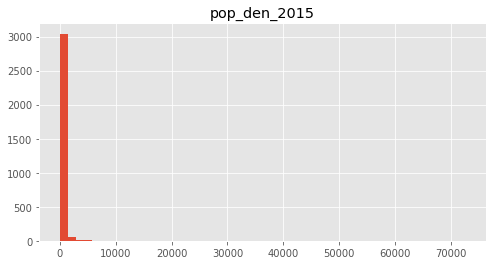

In [9]:
pop_density.hist('pop_den_2015', bins=50, figsize=(8,4));

# master[master['County_Code'] == 36081]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0b8796b978>]], dtype=object)

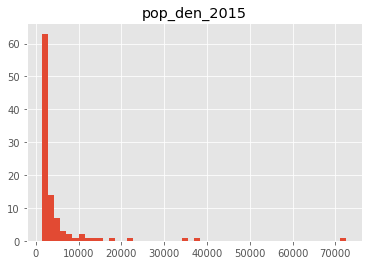

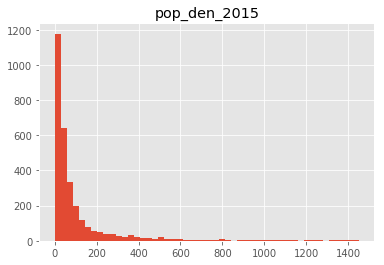

In [10]:
# split the top 100 counties by density from the rest of the counties

pop_last_100 = pop_density.sort_values('pop_den_2015')[-100:]
pop_everything_else = pop_density.sort_values('pop_den_2015')[:-100]
pop_last_100.hist('pop_den_2015', bins=50)
pop_everything_else.hist('pop_den_2015', bins=50)

This suggests that most counties are mostly white. The magnitude in the plot makes the data look imporobable, but 
the census bureau reported that as of 2016, 76.9% of the population is white. 

See https://www.census.gov/quickfacts/fact/table/US/PST045216 for further details


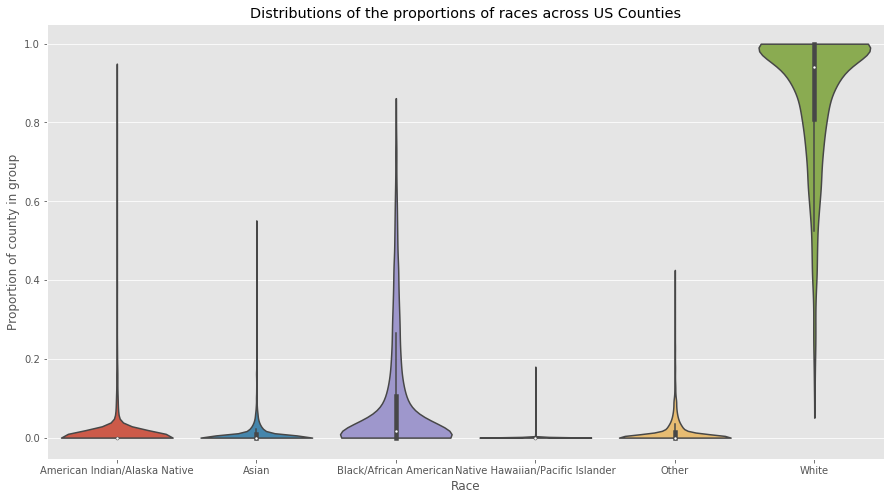

In [11]:
fig, ax = plt.subplots(1, figsize=(15,8))

sns.violinplot(data=race_pivot.loc[:,['American Indian/Alaska Native', 'Asian',
       'Black/African American', 'Native Hawaiian/Pacific Islander', 'Other',
       'White']],ax=ax, scale='count', cut=0);

ax.set_ylabel('Proportion of county in group')
ax.set_xlabel('Race')
ax.set_title('Distributions of the proportions of races across US Counties');
print('This suggests that most counties are mostly white. The magnitude in the plot makes the data look imporobable, but \n\
the census bureau reported that as of 2016, 76.9% of the population is white. \n\n\
See https://www.census.gov/quickfacts/fact/table/US/PST045216 for further details')

In [12]:
predom_white_counties = race_pivot[race_pivot['White']>=.7]
num_white_counties = len(predom_white_counties)
num_counties = len(race_pivot)
pop_US_total = race_pivot['Single_Race_Population'].sum()
pop_in_white_counties = predom_white_counties['Single_Race_Population'].sum()
percent_in_white_counties = (pop_in_white_counties/pop_US_total)*100
print('There are {} counties with at least 70% white population out of a total of {} counties in the United States'.\
      format(num_white_counties,num_counties))
print('The total population in predominantly white counties is {:.0f}, which is about {:.0f}% of the total pop'.\
     format(pop_in_white_counties,percent_in_white_counties))

There are 2662 counties with at least 70% white population out of a total of 3140 counties in the United States
The total population in predominantly white counties is 204533298, which is about 67% of the total pop


In [13]:
birth_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 7 columns):
State              3142 non-null int64
State_Name         3142 non-null object
County_Name        3142 non-null object
Pop_2015           3142 non-null int64
Births_2015        3142 non-null int64
Birth_Rate_2015    3142 non-null float64
County_Code        3142 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 171.9+ KB


In [14]:
'''Merge data then select for just predictors that we care about'''

merged_data = quintiles.merge(birth_rate, on='County_Code')
merged_data = merged_data.merge(race_pivot, on=['County_Code','County_State'])
merged_data = merged_data.merge(pop_density, on='County_Code')
merged_data = merged_data.merge(education_25yr, on=['County_Code','County_State'])
predictors_target = merged_data.loc[:, ['County_Code', 'County_Name','State_Name',\
                                        'Diff Top5%-LowestQ','Birth_Rate_2015', 'American Indian/Alaska Native',\
                                        'Asian','Black/African American', 'Native Hawaiian/Pacific Islander',\
                                        'Other','White', 'pop_den_2015','Less than 9th grade',\
                                        '9th to 12th grade, no diploma','High school graduate (includes equivalency)',\
                                        'Some college, no degree', "Associate's degree", "Bachelor's degree",\
                                        'Graduate or professional degree']]

In [15]:
predictors_target.head()

,County_Code,County_Name,State_Name,Diff Top5%-LowestQ,Birth_Rate_2015,American Indian/Alaska Native,Asian,Black/African American,Native Hawaiian/Pacific Islander,Other,White,pop_den_2015,Less than 9th grade,"9th to 12th grade, no diploma",High school graduate (includes equivalency),"Some college, no degree",Associate's degree,Bachelor's degree,Graduate or professional degree
0,1001,Autauga County,Alabama,227339,10.846281,0.000000,0.000000,0.194417,0.0,0.000000,0.805583,93.107956,0.038382,0.089815,0.335417,0.225860,0.078224,0.134833,0.097470
1,1003,Baldwin County,Alabama,272508,11.104997,0.006082,0.006817,0.097719,0.0,0.009754,0.879629,128.134341,0.032007,0.072810,0.287815,0.226860,0.090656,0.192612,0.097240
2,1005,Barbour County,Alabama,159870,10.093051,0.000000,0.000000,0.479280,0.0,0.035313,0.485407,29.935234,0.092088,0.174872,0.345066,0.191036,0.071778,0.075074,0.050085
3,1007,Bibb County,Alabama,209597,11.211557,0.000000,0.000000,0.218554,0.0,0.000000,0.781446,36.273075,0.069486,0.124000,0.420628,0.218376,0.061040,0.060529,0.045940
4,1009,Blount County,Alabama,167062,10.456859,0.000000,0.000000,0.015852,0.0,0.000000,0.984148,89.442267,0.069656,0.145326,0.334424,0.223990,0.097696,0.086175,0.042732


In [16]:
def corr_heat(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(12, 12))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},xticklabels=corr.index, yticklabels=corr.columns)
    plt.xticks(rotation=60, ha="right")
    plt.yticks(rotation=0)
    ax.set_title("Correlation Heat Map")
    plt.show()

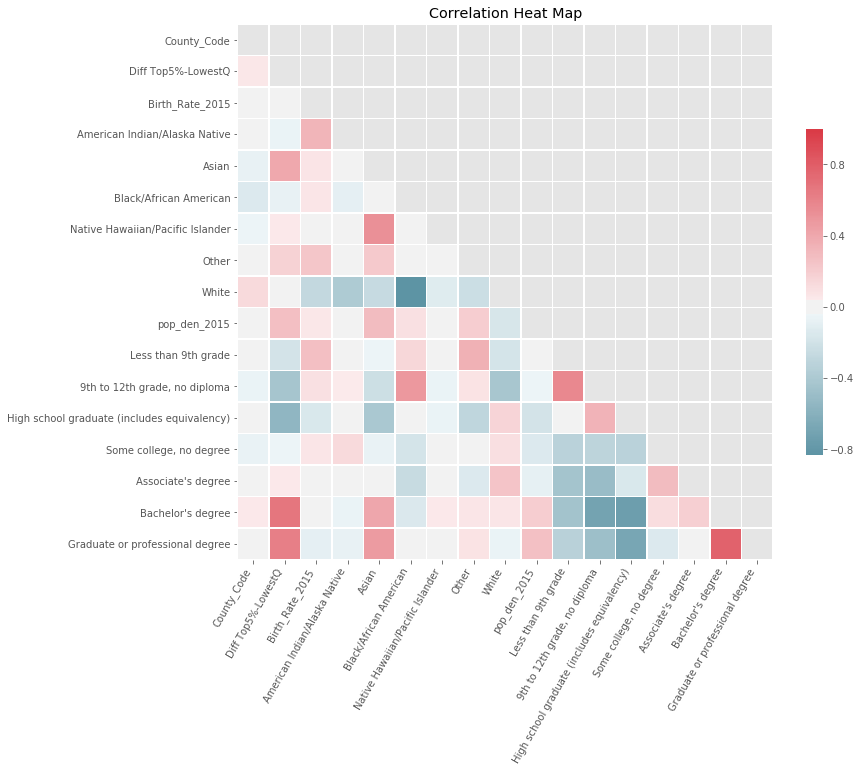

In [17]:
corr_heat(pd.DataFrame(predictors_target))

Covariance Notes:
- Covariance between proportion of pop with a Bachelor's degree and proportion of pop with a graduate degree. **How deal with this? Chose one? Can somehow parse out into parts that don't covary?**
- High covariance between proportion of Bachelor's/Grad degrees and income inequality. This is the opposite of what I expected given that higher education is said to facilitate socioeconomic mobility while income inequality hinders it.
- Higher proportion of population with High School as highest level of educational attainment strongly *inversely* covaries with income inequality. Is this because in those towns, everybody is poor?

/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


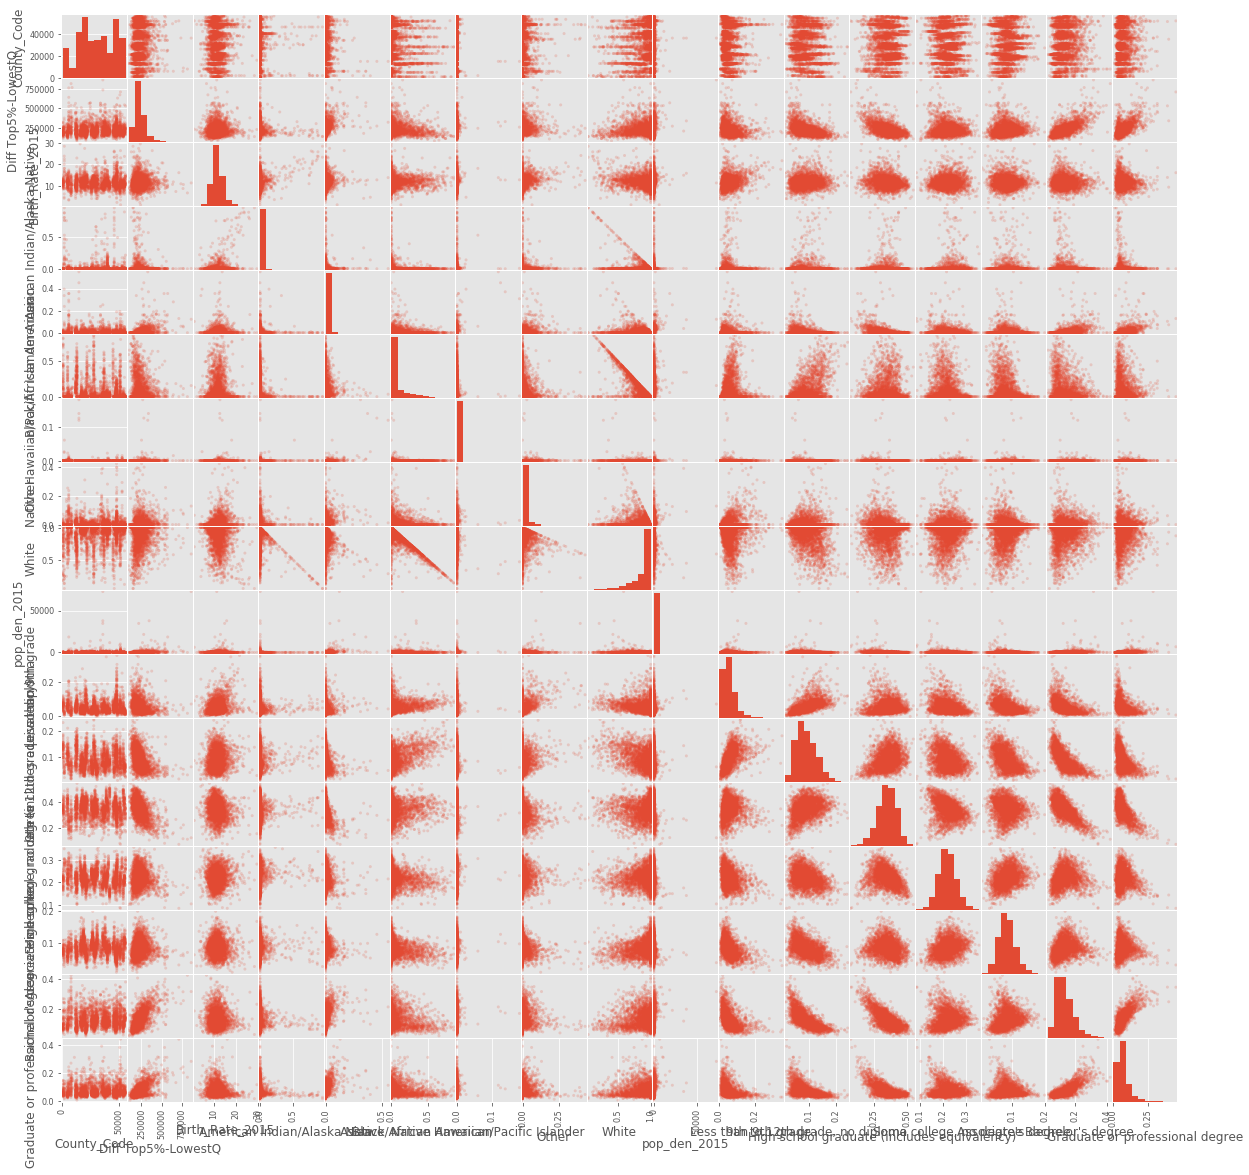

In [18]:
scattermatrix = scatter_matrix(predictors_target, alpha=0.2,figsize=(20,20), diagonal="hist")

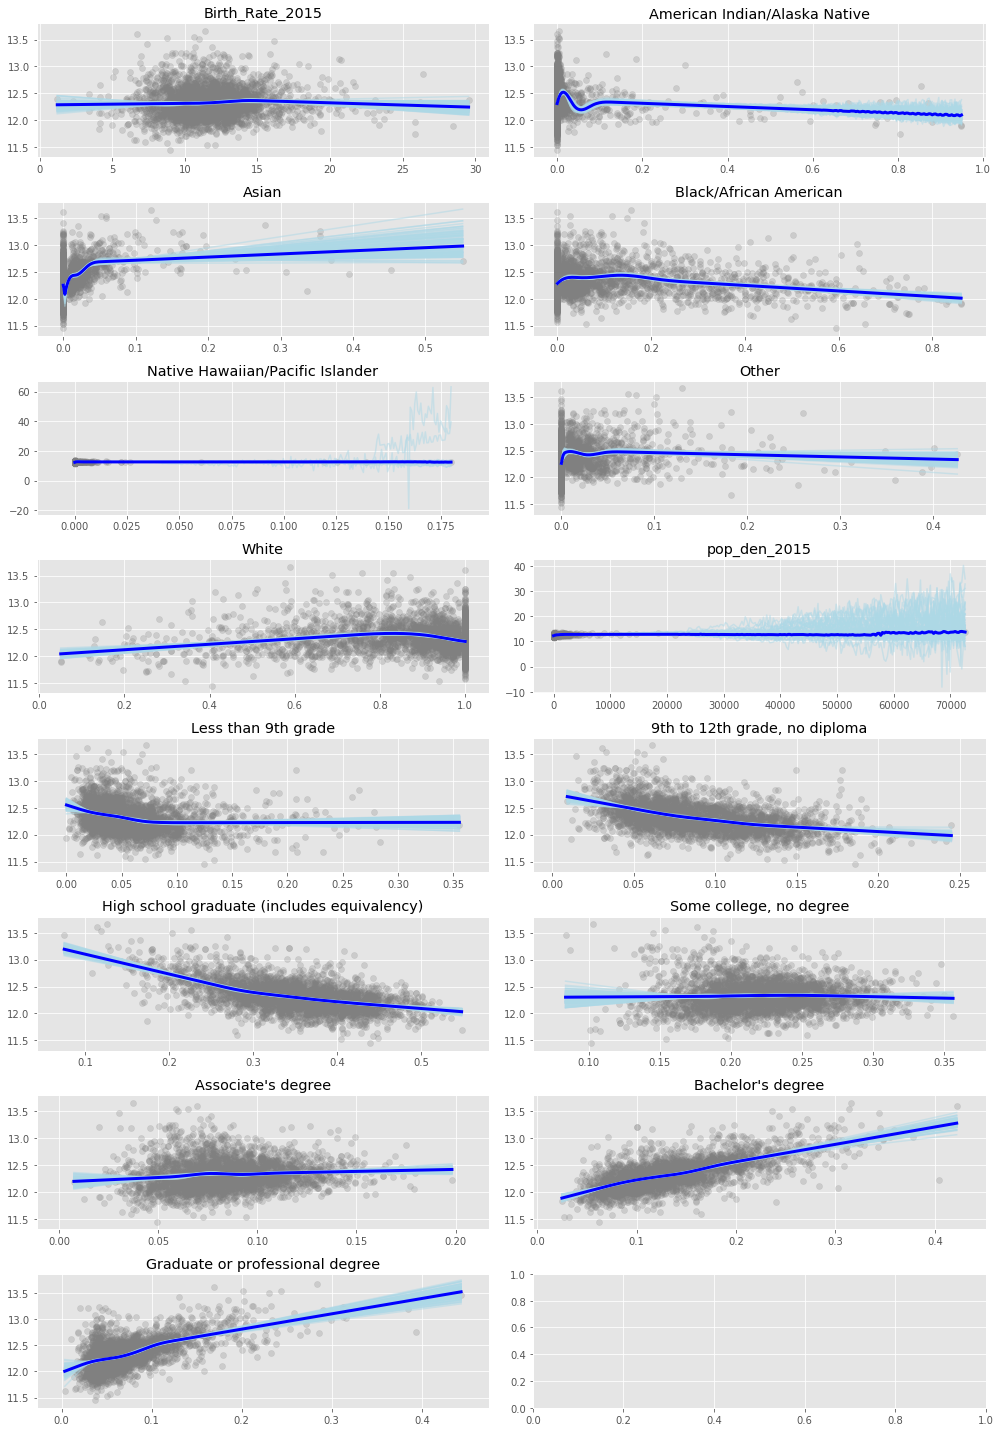

In [19]:
#Plot univariate plots against log of income inequality
fig, axs = plt.subplots(8, 2, figsize=(14, 20))
l1=['Birth_Rate_2015', 'American Indian/Alaska Native',\
    'Asian','Black/African American', 'Native Hawaiian/Pacific Islander',\
    'Other','White', 'pop_den_2015','Less than 9th grade',\
    '9th to 12th grade, no diploma','High school graduate (includes equivalency)',\
    'Some college, no degree', "Associate's degree", "Bachelor's degree",\
    'Graduate or professional degree']

univariate_plot_names = predictors_target[l1]

for name, ax in zip(univariate_plot_names, axs.flatten()):
    plot_univariate_smooth(ax,
                           predictors_target[name].values.reshape(-1, 1),
                           np.log(predictors_target['Diff Top5%-LowestQ']),
                           bootstrap=100)
    ax.set_title(name)
fig.tight_layout()

## Summary of EDA

### Source data considerations
- Race data only described people who identify as a single race, so it does not include everyone in the population.
- Education data only includes people 25 or older as that seems to be the standard way the census measures a population's educational attainment. 

### Impressions from data visualization
- Target variable, income inequality, not normally distributed because:
            + Extreme values
            + Zero bound
    - To deal with this, took the log of the target in the target variable, which resulted in a more normal distribution
- American counties are heavily weighted toward white populations

### Variable treatment to-do:
- Need to deal with high covariance and inverse covariance in predictors
- variables are mostly linearly related with the log of income inequality. Exceptions are:
    - Asian - weighted by zeros but in a way that looks like it might be significant
    - White - right around 90% it looks like an increase in proportion of whites results in a decrease in income inequality
    - Less than 9th grade, apparent inflection point at 7.5%
- Add in states dummies

In [20]:
# Pipeline
# get rid of outliers
# standardize to mean 0 and stdev = 1
# spline the variables that aren't linearly related with target


- ANOVA for states - does log(income_inequality) vary significantly by state
- lasso linear regression for interpretability of coefficients
- k fold to determine alpha for lasso
- train_test_split
    - stratify sample by state if including state as explanatory variable
    - potential supplement state samples with techniques from Monday
- bootstrap